# Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

2025-03-06 11:54:12.747486: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 11:54:12.895396: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 11:54:13.026154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741280053.124596    1948 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741280053.158639    1948 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 11:54:13.506089: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

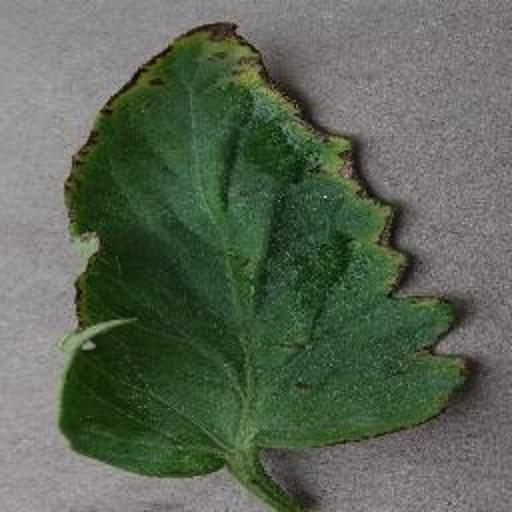

In [2]:
image = Image.open("../dataset/train/Bacteria/image_255.jpg")
image.show()

In [3]:
image.size

(512, 512)

# Train, Val, and Test Dataset

In [4]:
import tensorflow as tf
dataset_dir = "../dataset/train"

# Load dataset
full_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    batch_size=4,  # Adjust batch size as needed
    label_mode="categorical",
    seed=2025
)

Found 39997 files belonging to 5 classes.


2025-03-06 11:54:40.631925: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:

# Unbatch the dataset
full_ds = full_ds.unbatch()

# Calculate dataset size
dataset_size = sum(1 for _ in full_ds)
print("Dataset size:", dataset_size)

# Shuffle dataset
full_ds = full_ds.shuffle(dataset_size, seed=2025)

# Define split sizes
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

# Split dataset
train_ds = full_ds.take(train_size)
remaining_ds = full_ds.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)  # The rest is for testing

# Batch datasets
batch_size = 32  # You can change this
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)  # If needed


Dataset size: 39997


2025-03-06 11:55:12.008936: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Looking at the Batch

In [6]:
# Get one batch from train_ds
batch = next(iter(train_ds))

# Extract images and labels from the batch
images, labels = batch

# Get the first image and label
one_image = images[0]
one_label = labels[0]

# Show shape
print(f"Image shape: {one_image.shape}, Label: {one_label.numpy()}")

# Plot the image
plt.imshow(one_image.numpy().astype("uint8"))  # Convert to uint8 if needed
plt.title(f"Label: {one_label.numpy()}")
plt.axis("off")
plt.show()


2025-03-06 11:56:10.942513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 5029 of 39997
2025-03-06 11:56:30.862332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 7706 of 39997
2025-03-06 11:56:40.878738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 12340 of 39997
2025-03-06 11:56:50.899287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 17952 of 39997


: 

# Search the best model

In [17]:
import keras_tuner as kt

def build_model(hp):
    # Hyperparameters
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])

    # Optimizer selection
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Model definition
    model = tf.keras.Sequential([
        # Normalize input: Rescale pixel values (0-255) to (0-1)
        tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),

        # Flatten before passing to dense layers
        tf.keras.layers.Flatten()
    ])
    
    # Add hidden layers based on hyperparameter tuning
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))

    # Output layer (assuming 10 classes, adjust if needed)
    model.add(tf.keras.layers.Dense(5, activation="softmax"))

    # Compile the model
    model.compile(
        loss="categorical_crossentropy",  # ✅ Use this for one-hot labels #loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=3,  # Run each model once
    directory="kt_logs",
    project_name="image_classification_tuning"
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",  # 🔍 Monitor validation loss
    patience=10,  # ⏳ Stop after 10 epochs without improvement
    restore_best_weights=True  # ♻️ Revert to the best model
)

tuner.search(train_ds, 
            validation_data=val_ds, 
            epochs=100,
            callbacks=[early_stopping_cb])


/mnt/c/Users/angel/Documents/baldwin/Pathogen_classification/backend/venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
6                 |6                 |n_hidden
107               |107               |n_neurons
0.0072462         |0.0072462         |learning_rate
sgd               |sgd               |optimizer



2025-03-06 10:02:54.582224: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 84148224 exceeds 10% of free system memory.
2025-03-06 10:02:54.738946: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 84148224 exceeds 10% of free system memory.
2025-03-06 10:02:54.880450: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 84148224 exceeds 10% of free system memory.


Epoch 1/10


2025-03-06 10:02:56.490918: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 84148224 exceeds 10% of free system memory.


   2/7000 ━━━━━━━━━━━━━━━━━━━━ 21:13 182ms/step - accuracy: 0.0625 - loss: 1.6454   

2025-03-06 10:02:57.026658: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 84148224 exceeds 10% of free system memory.


7000/7000 ━━━━━━━━━━━━━━━━━━━━ 1526s 218ms/step - accuracy: 0.2965 - loss: 1.4786 - val_accuracy: 0.3785 - val_loss: 1.3188
Epoch 2/10
2999/7000 ━━━━━━━━━━━━━━━━━━━━ 9:57 149ms/step - accuracy: 0.3644 - loss: 1.3589

KeyboardInterrupt: 

# Best model

In [ ]:
top3_models = tuner.get_best_models(num_models=3) 
best_model = top3_models[0]

In [18]:
from pathlib import Path 
from time import strftime 

def get_run_logdir(root_logdir="my_logs"):
	return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S") 

run_logdir = get_run_logdir()

In [ ]:
# Define the TensorBoard callback
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=run_logdir)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_{epoch:02d}-{val_loss:.2f}.weights.h5", 
                                                    save_weights_only=True,
                                                    save_freq="epoch"
                                                    )

In [ ]:
best_model.fit(train_ds, 
                epochs=10,
                validation_data=val_ds,
                callbacks=[tensorboard_cb, checkpoint_cb]
                ) 

test_loss, test_accuracy = best_model.evaluate(test_ds) 

In [ ]:

# Normalize images (optional)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))